## Toxic comment classification
### Import library

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 42
import os
os.environ['OMP_NUM_THREADS'] = '4'


c:\Users\Hashi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read data set

In [3]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)
print('Number of rows and columns in the test data set:',test_labels.shape)

Number of rows and columns in the train data set: (159571, 8)
Number of rows and columns in the test data set: (153164, 2)
Number of rows and columns in the test data set: (153164, 7)


# Data Cleaning and Preprocessing

**1. Preprocessing:**
   - *Lowercasing:* All text is converted to lowercase for uniformity.
   - *Punctuation, Digits, and Stop Word Removal:* Removing unnecessary elements to focus on meaningful content.
   - *Lemmatization:* Reducing words to their base or root form for consistency.

**2. Checking Data Imbalance:**
   - Prior to modeling, it's crucial to address any imbalance between toxic and non-toxic comments.
   - A thorough examination of label distribution is conducted to identify potential biases.

**3. Merging:**
   - Combining relevant datasets to create a comprehensive and unified dataset.
   - Ensuring consistency in data structure and format for effective model testing.

**Advantages of Chosen Preprocessing Techniques:**
   - *Interpretability:* The preprocessing steps enhance interpretability by ensuring a consistent representation of words.
   - *Efficiency:* The chosen techniques are computationally efficient, suitable for our dataset's characteristics.
   - *Simplicity:* The approach is straightforward, facilitating a clear understanding of the preprocessing pipeline.

**Handling Data Imbalance:**
   - To address class imbalance, random sampling is employed between clean and unclean comments.
   - This ensures a balanced representation in the training data, preventing model bias and enhancing generalization.

**Note:** The preprocessing and cleaning steps are critical in preparing the data for subsequent modeling tasks, such as classification using TF-IDF and logistic regression/Naive Bayes.


### VISUALISATION
##### Need to check where cleaning, merging etc is required

In [4]:
# Visualizing how our train data set looks like
train.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Visualizing how our test data set looks like
test.head()
#  Turns out we dont have labels attached to test data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
#Interesting same IDS, maybe we can mrgee them? :) and -1 represnt dont care as per kaggle file as appretnly for a tournament or submissoin.
test_labels.head()



,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


## Merge Dataset

In [7]:

test = pd.merge(test, test_labels, on='id')
test.head()
# Merging on comment on ID, but lets see -1 still there


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [8]:
#  Lets drop -1s
test = test[(test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] != -1).all(axis=1)]
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [9]:
##still decent rows after removing -1. 
print('Number of rows and columns in the test data set:',test.shape)


Number of rows and columns in the test data set: (63978, 8)


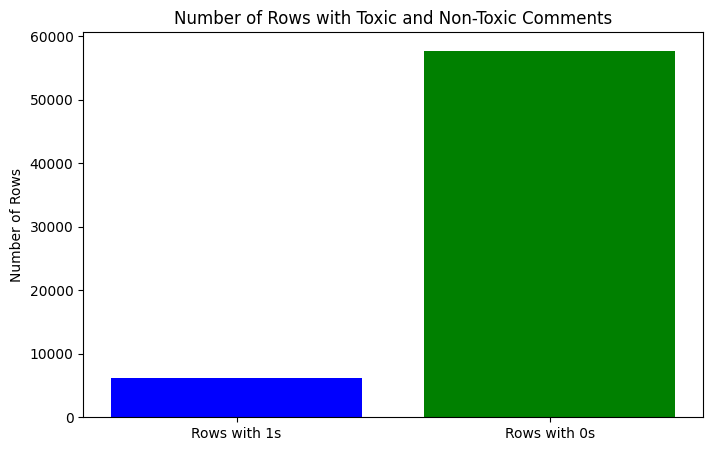

In [10]:
# Objective: Check for the presence of rows with label '1' in any of the specified label columns,
# count the number of rows with at least one '1', and count the rows with all '0's.

# Checking if there are rows with label '1' in any of the label columns
num_rows_with_ones = (test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 1).any(axis=1).sum()

# Counting the number of rows with at least one '1' and rows with all '0's
num_rows_with_zeros = (test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 0).all(axis=1).sum()

# Data for plotting
categories = ['Rows with 1s', 'Rows with 0s']
counts = [num_rows_with_ones, num_rows_with_zeros]

# Creating a bar chart to visualize the counts
plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'green'])
plt.title('Number of Rows with Toxic and Non-Toxic Comments')
plt.ylabel('Number of Rows')
plt.show()

## So test data is imbalanced but we really don't care about that; what we just wanted to prove was the existence of rows with '1' values indicating 
# column values are present.


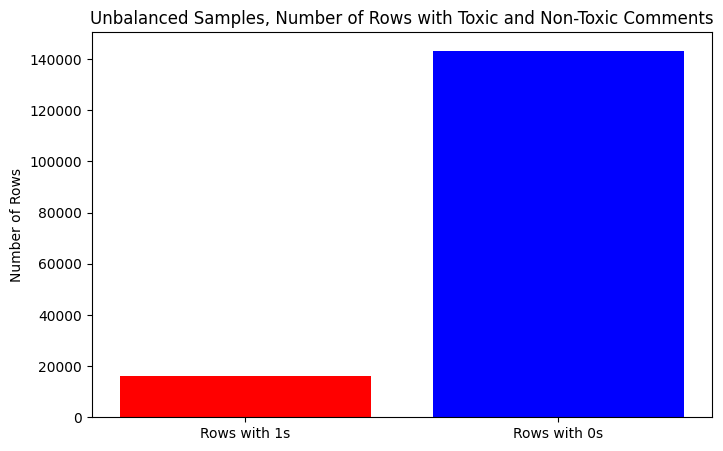

In [11]:
# Check if there is imbalance in train data set
# Checking if there are rows with label '1' in any of the label columns
# Counting the number of rows with at least one '1' and rows with all '0's
num_rows_with_ones = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 1).any(axis=1).sum()
num_rows_with_zeros = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 0).all(axis=1).sum()



# Data for plotting
categories = ['Rows with 1s', 'Rows with 0s']
counts = [num_rows_with_ones, num_rows_with_zeros]

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['red', 'blue'])
plt.title('Unbalanced Samples, Number of Rows with Toxic and Non-Toxic Comments')
plt.ylabel('Number of Rows')
plt.show()

## OBVIUS data imbalance presnet in Train columns we need to fix this as we did run withut intially sampling but F1 scores and recalls were low as aalready mentioned on slack





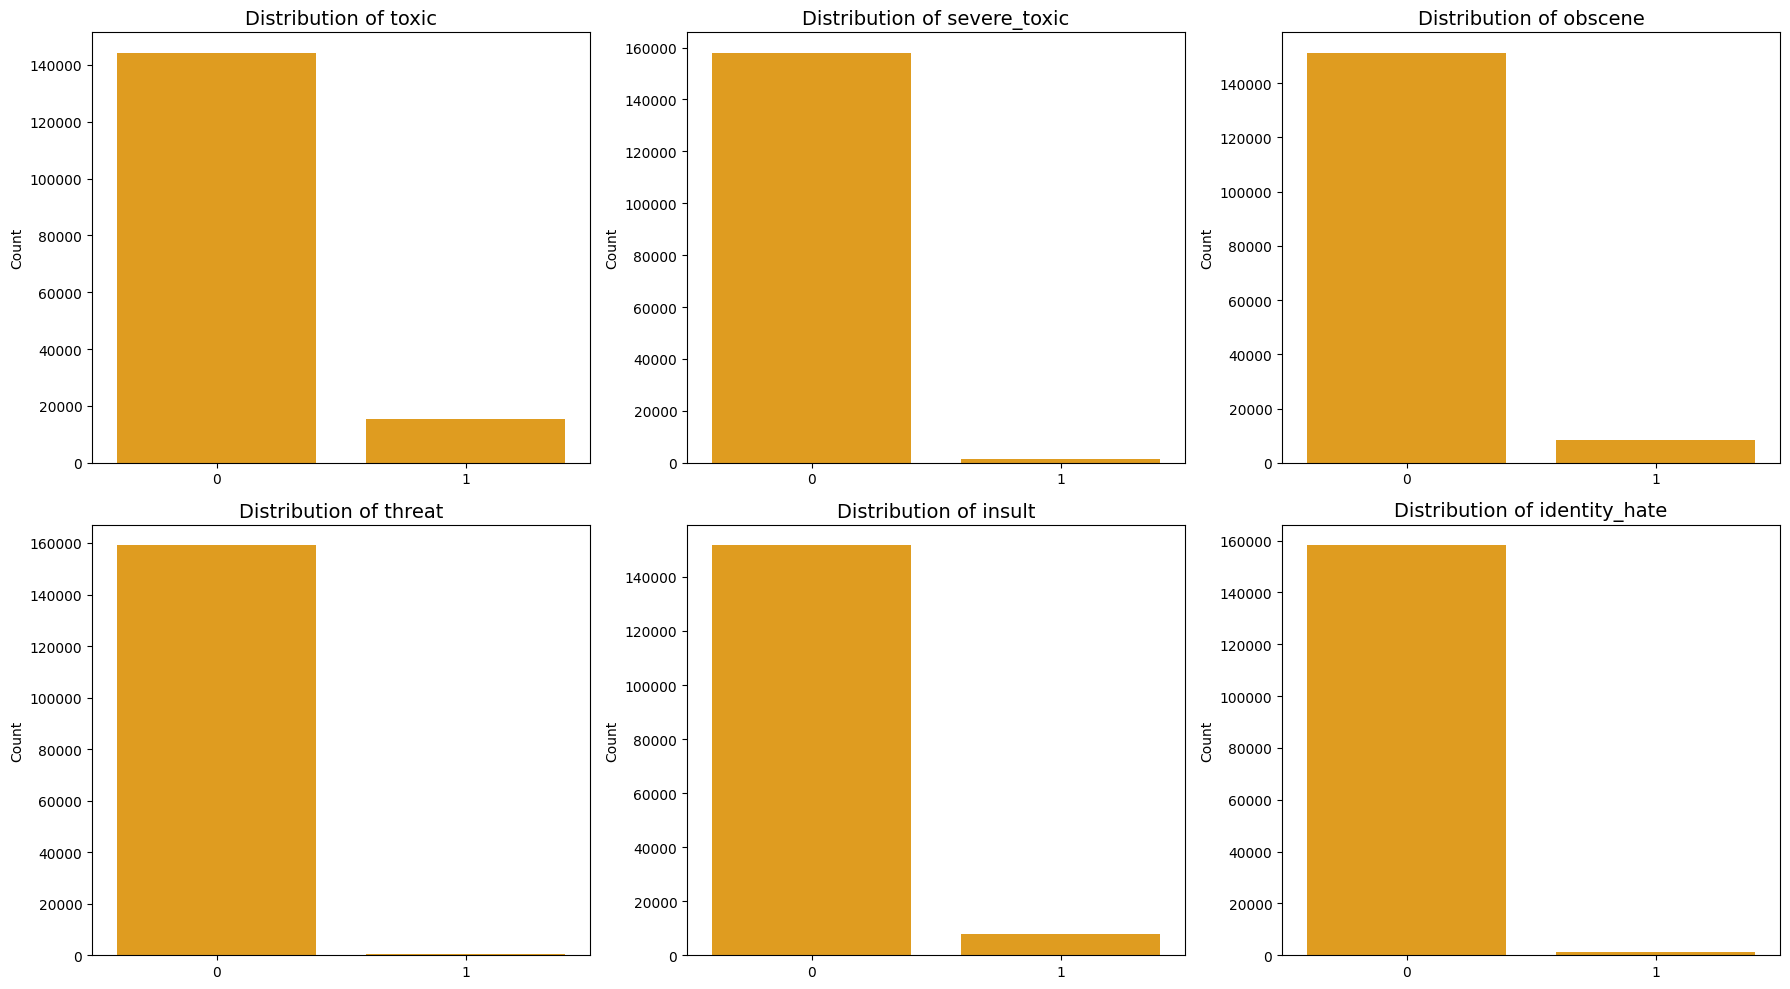

In [12]:
# Objective: Visualizing the Distribution of Each Label in the Training Data

# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Defining the target columns
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Creating subplots for count plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Iterating through each target column
for i, col in enumerate(target_cols):
    # Creating a count plot for the current label
    sns.countplot(x=train[col], ax=axes[i], color='orange')
    
    # Setting plot title
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    
    # Removing x-axis label for clarity
    axes[i].set_xlabel('')
    
    # Setting y-axis label
    axes[i].set_ylabel('Count')

# Adjusting layout for better visualization
plt.tight_layout()

# Displaying the plot
plt.show()

# Note: The count plots illustrate the distribution of each label in the training data.
# It is evident that the data for label '1' (indicating the presence of toxicity) is significantly less for some columns.


In [13]:
# Objective: Balancing the Dataset by Undersampling Non-Toxic Comments

# Separating the dataset into two groups: toxic and non-toxic comments
toxic_comments = train[(train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 1).any(axis=1)]
non_toxic_comments = train[(train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 0).all(axis=1)]

# Counting the number of instances in each group
num_toxic = len(toxic_comments)
num_non_toxic = len(non_toxic_comments)

# Displaying the number of toxic and non-toxic comments
print("Number of toxic comments =", num_toxic)
print("Number of non-toxic comments =", num_non_toxic)

# Performing undersampling to balance the dataset
if num_non_toxic > num_toxic:
    non_toxic_sample = non_toxic_comments.sample(n=num_toxic, random_state=seed)  # Randomly selecting 'num_toxic' rows
    balanced_train = pd.concat([toxic_comments, non_toxic_sample])
else:
    toxic_sample = toxic_comments.sample(n=num_non_toxic, random_state=seed)  # Randomly selecting 'num_non_toxic' rows
    balanced_train = pd.concat([toxic_sample, non_toxic_comments])

# Shuffling the dataset
train = balanced_train.sample(frac=1, random_state=seed).reset_index(drop=True)

# Note: This code balances the dataset by undersampling non-toxic comments.
# The number of toxic and non-toxic comments is displayed, and the dataset is shuffled for training.


Number of toxic comments = 16225
Number of non-toxic comments = 143346


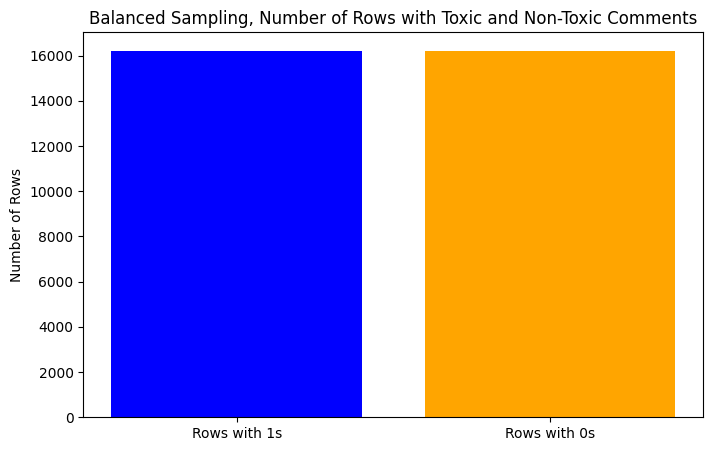

In [14]:
# Objective: Checking and Visualizing Imbalance in the Dataset

# Checking if there are rows with label '1' in any of the label columns
# Counting the number of rows with at least one '1' and rows with all '0's
num_rows_with_ones = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 1).any(axis=1).sum()
num_rows_with_zeros = (train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 0).all(axis=1).sum()

# Data for plotting
categories = ['Rows with 1s', 'Rows with 0s']
counts = [num_rows_with_ones, num_rows_with_zeros]

# Plotting the imbalance in the dataset
plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'orange'])
plt.title('Balanced Sampling, Number of Rows with Toxic and Non-Toxic Comments')
plt.ylabel('Number of Rows')
plt.show()

# Note: This code checks for the presence of rows with label '1' in any of the label columns and counts the number of rows
# with at least one '1' and rows with all '0's. The results are visualized using a bar plot to highlight the data imbalance
# present in the train columns. The imbalance issue is addressed through balanced sampling for improved model performance.


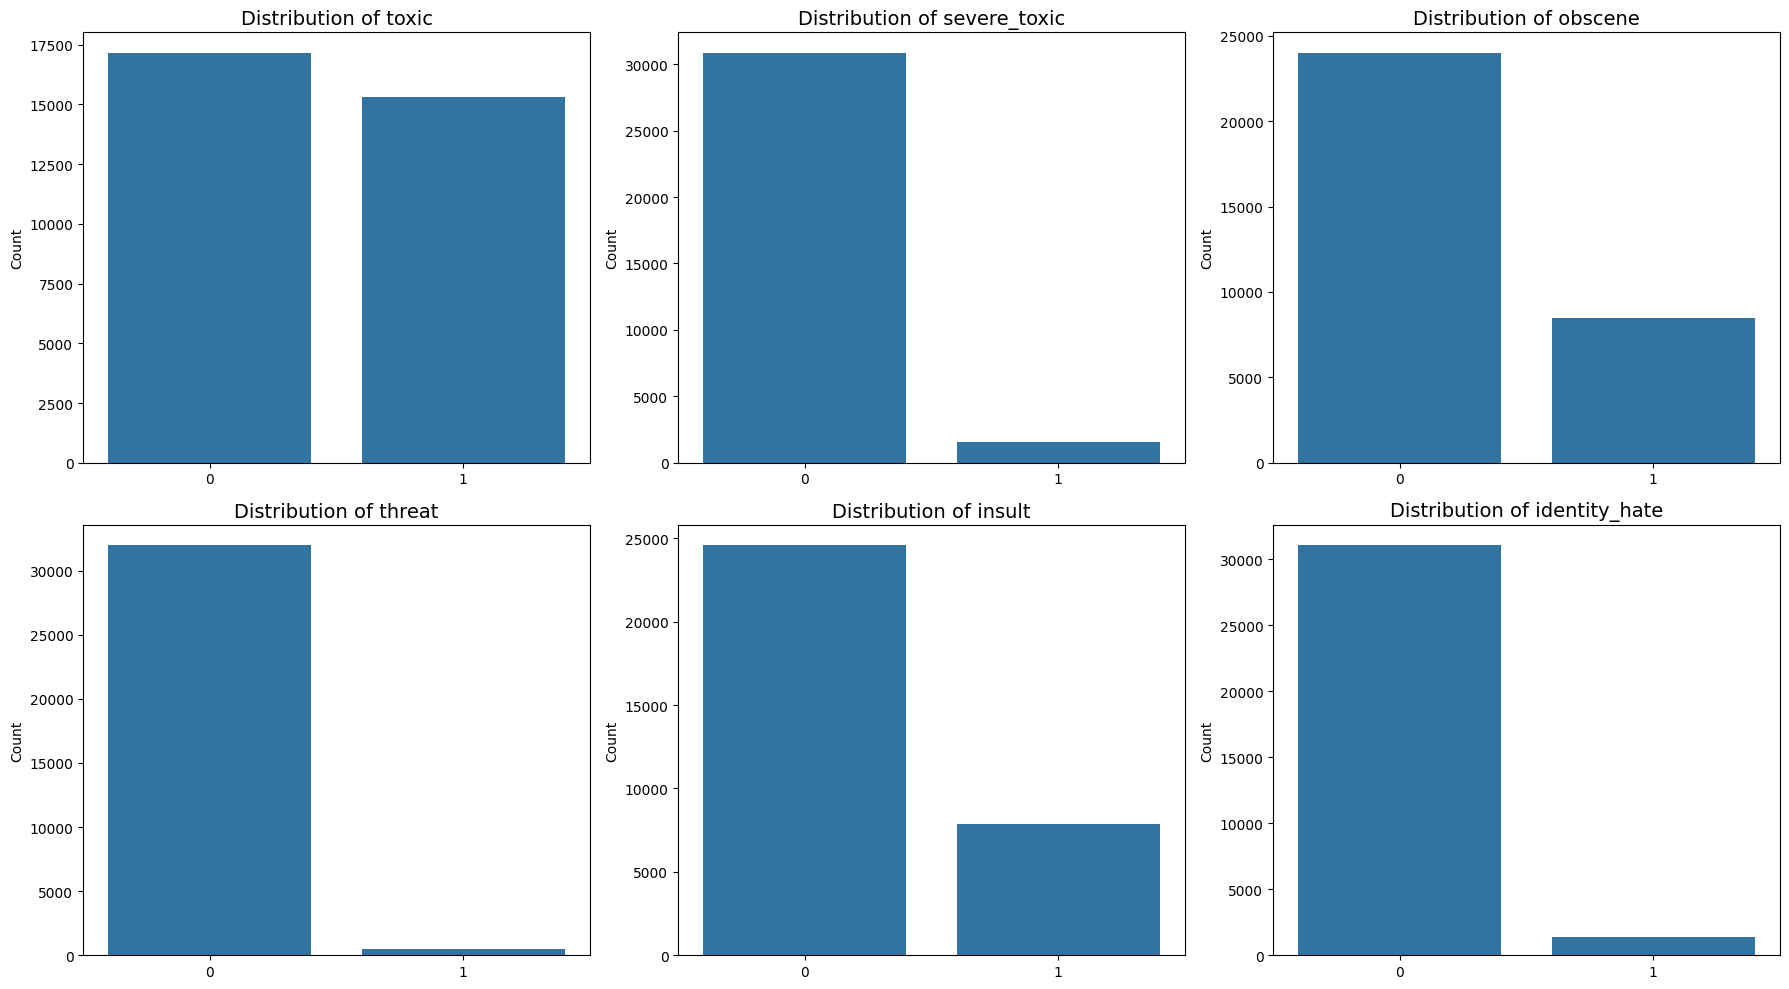

In [15]:
# Objective: Analyzing Data Imbalance within each class and Considering Balancing Options

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Countplot for Each Label
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Loop through each label column for countplot
for i, col in enumerate(target_cols):
    sns.countplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

# Display the plot
plt.tight_layout()
plt.show()

# Note: This code creates a countplot for each label column to analyze the distribution of toxic and non-toxic comments.
# A consideration is mentioned about balancing all columns with '0s' and '1s' to address the imbalance.
### CONCLUSION: We cannot balance the indiviual classes due to scarcity of data

## Missing value

In [16]:
# Objective: Analyzing Missing Data in Train, Test, and Label Datasets

import pandas as pd

# Create an empty DataFrame to store missing data information
dataset = pd.DataFrame()

# Count the missing values in the train, test, and label datasets
dataset['train'] = train.isnull().sum()
dataset['test'] = test.isnull().sum()
dataset['train_label'] = test_labels.isnull().sum()

# Display the dataset showing the count of missing values
dataset


,train,test,train_label
id,0,0,0.0
comment_text,0,0,NaN
toxic,0,0,0.0
severe_toxic,0,0,0.0
obscene,0,0,0.0
threat,0,0,0.0
insult,0,0,0.0
identity_hate,0,0,0.0


In [17]:
test[test['comment_text'].isnull()]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [18]:
test.fillna(' ',inplace=True)


### TEXT PREPROCESSING 

In [19]:
import re
import string

import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    """
    Applies various preprocessing steps such as lowercasing, removing punctuation,
    removing stopwords, and lemmatization to the input text.
    
    Args:
    text (str): The text to be preprocessed.
    
    Returns:
    str: Preprocessed text.
    """
    # Lowercasing
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Handling Emojis and Slangs (Extend your emoji dictionary as needed)
    emoji_dict = {':)': 'happy', ':(': 'sad'}  # Add more mappings
    for emoji, meaning in emoji_dict.items():
        text = text.replace(emoji, ' ' + meaning + ' ')

    return text

train['comment_text'] = train['comment_text'].apply(preprocess_text)
test['comment_text'] = test['comment_text'].apply(preprocess_text)



[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Hashi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Text Vectorization Process

To convert the raw text into a format suitable for model training, we perform text vectorization using TF-IDF (Term Frequency-Inverse Document Frequency) with both word and character n-grams. We utilize two separate vectorizers for words and characters, each configured with specific parameters.

### Word N-gram Vectorization

For word n-gram vectorization, we use the following configuration:

- **Maximum Features (max_features):** 20,000, limiting the vocabulary size.
- **Lowercasing:** Enabled.
- **Analyzer:** Word-level.
- **Stop Words:** English.
- **N-gram Range:** (1, 3), considering unigrams, bigrams, and trigrams.

### Character N-gram Vectorization

For character n-gram vectorization, the configuration is as follows:

- **Maximum Features (max_features):** 40,000, limiting the character vocabulary.
- **Lowercasing:** Enabled.
- **Analyzer:** Character-level.
- **Stop Words:** English.
- **N-gram Range:** (3, 6), considering trigrams to hexagrams.

### Combined Feature Matrix

We create a combined feature matrix by stacking the word n-gram vector and character n-gram vector horizontally.

```python
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])


In [20]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [21]:
# Word ngram vector
tr_vect = vect_word.fit_transform(train['comment_text'])
ts_vect = vect_word.transform(test['comment_text'])

# Character n gram vector
tr_vect_char = vect_char.fit_transform(train['comment_text'])
ts_vect_char = vect_char.transform(test['comment_text'])


In [22]:
X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

In [23]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]
del tr_vect, ts_vect, tr_vect_char, ts_vect_char


## Model:
### Naive Bayes Classification

To perform multi-label classification on our toxic comment dataset, we chose the Naive Bayes classifier, specifically the Multinomial Naive Bayes model from scikit-learn. The decision to use Naive Bayes is based on several considerations:

### Text Classification Suitability

Naive Bayes is well-suited for text classification tasks, making it an appropriate choice for our toxic comment classification problem. Its effectiveness lies in its simplicity and the assumptions it makes about the independence of features, aligning with the nature of our text data.

### Efficiency

Naive Bayes models are computationally efficient, making them suitable for datasets with a high number of features. In our case, the abundance of words and characters in the comments makes the efficiency of Naive Bayes advantageous for the classification task.

### Independence Assumption Alignment

The independence assumption of features in Naive Bayes aligns with the nature of our text data. Each word or character is treated as a feature, and although the independence assumption may not hold perfectly, Naive Bayes often performs well in practice for text classification tasks.

### Baseline Model

Naive Bayes serves as a baseline model, providing a simple yet effective starting point for multi-label classification. Its simplicity makes it easy to interpret and understand, and it provides a benchmark against which more complex models can be compared.

In summary, the choice of Naive Bayes is driven by its suitability for text classification, computational efficiency, alignment with the independence assumption in text data, and its role as a foundational baseline model.


In [24]:
# Objective: Building Multinomial Naive Bayes Model for Multi-Label Classification

# Importing the Multinomial Naive Bayes class from scikit-learn
from sklearn.naive_bayes import MultinomialNB

# Initializing an array to store the predicted probabilities for each label
prd = np.zeros((x_test.shape[0], y.shape[1]))

# Initializing an empty list to store cross-validation scores (not used in the provided code)
cv_score = []

# Looping through each target column (label) for multi-label classification
for i, col in enumerate(target_col):
    # Creating a Multinomial Naive Bayes model instance
    nb = MultinomialNB()
    
    # Printing a message indicating the model building process
    print('Building {} model for column: {}'.format(i, col))
    
    # Fitting the Naive Bayes model on the training data for the current label
    nb.fit(X, y[col])
    
    # Predicting probabilities for the test set and storing them in the 'prd' array
    prd[:, i] = nb.predict_proba(x_test)[:, 1]

# Note: This code builds a Multinomial Naive Bayes model for each label in the multi-label classification task.
# It prints messages indicating the model-building process for each label and stores the predicted probabilities.
# The 'cv_score' list is initialized but not used in the provided code.
# The resulting 'prd' array contains the predicted probabilities for each label on the test set.
# The final step involves creating a DataFrame ('prediction_scores_df') to store these probabilities, but it's commented out.
# This code snippet demonstrates the utilization of Naive Bayes for multi-label classification.


Building 0 model for column: toxic
Building 1 model for column: severe_toxic
Building 2 model for column: obscene
Building 3 model for column: threat
Building 4 model for column: insult
Building 5 model for column: identity_hate


In [25]:
# Objective: Creating Binary Predictions Based on Probability Threshold

# Creating a DataFrame to store predicted probabilities for each label
prediction_scores_df = pd.DataFrame(prd, columns=target_col)

# Setting a threshold for converting probabilities to binary predictions
threshold = 0.5

# Generating binary predictions based on the chosen threshold
test_pred_binary = (prd > threshold).astype(int)

# Note: This code creates a DataFrame ('prediction_scores_df') to store the predicted probabilities for each label.
# It also defines a threshold (0.5) for converting these probabilities into binary predictions.
# The resulting 'test_pred_binary' array contains binary predictions (0 or 1) based on the specified threshold.
# Adjusting the threshold allows for flexibility in controlling the trade-off between precision and recall.


In [26]:


ts_vect = vect_word.transform(test['comment_text'])



ts_vect_char = vect_char.transform(test['comment_text'])

x_test = sparse.hstack([ts_vect, ts_vect_char])

test.shape



(63978, 8)

## Model Validation on test data set

In [27]:
# Objective: Calculating Evaluation Metrics for Binary Predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Defining the target columns
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Assuming 'test' is your test DataFrame and 'test_pred_binary' contains the binary predictions
threshold = 0.5  # You can adjust this threshold
test_pred_binary = (prd > threshold).astype(int)

# Calculating metrics for each target column
for col in target_col:
    # Confusion matrix
    cm = confusion_matrix(test[col], test_pred_binary[:, target_col.index(col)])
    print(f"Confusion Matrix for {col}:")
    print(cm)

    # Accuracy, Precision, Recall, and F1-Scores for each class
    accuracy = accuracy_score(test[col], test_pred_binary[:, target_col.index(col)])
    precision_0 = precision_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=0)
    recall_0 = recall_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=0)
    f1_0 = f1_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=0)

    precision_1 = precision_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=1)
    recall_1 = recall_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=1)
    f1_1 = f1_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=1)

    # Displaying metrics
    print(f"Metrics for {col}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision for class 0: {precision_0:.2f}, Recall for class 0: {recall_0:.2f}, F1-Score for class 0: {f1_0:.2f}")
    print(f"Precision for class 1: {precision_1:.2f}, Recall for class 1: {recall_1:.2f}, F1-Score for class 1: {f1_1:.2f}")
    print('-' * 50)


Confusion Matrix for toxic:
[[48268  9620]
 [  723  5367]]
Metrics for toxic:
Accuracy: 0.84
Precision for class 0: 0.99, Recall for class 0: 0.83, F1-Score for class 0: 0.90
Precision for class 1: 0.36, Recall for class 1: 0.88, F1-Score for class 1: 0.51
--------------------------------------------------
Confusion Matrix for severe_toxic:
[[62871   740]
 [  171   196]]
Metrics for severe_toxic:
Accuracy: 0.99
Precision for class 0: 1.00, Recall for class 0: 0.99, F1-Score for class 0: 0.99
Precision for class 1: 0.21, Recall for class 1: 0.53, F1-Score for class 1: 0.30
--------------------------------------------------
Confusion Matrix for obscene:
[[56748  3539]
 [  847  2844]]
Metrics for obscene:
Accuracy: 0.93
Precision for class 0: 0.99, Recall for class 0: 0.94, F1-Score for class 0: 0.96
Precision for class 1: 0.45, Recall for class 1: 0.77, F1-Score for class 1: 0.56
--------------------------------------------------
Confusion Matrix for threat:
[[63678    89]
 [  204     7]

## Roc AUC curve

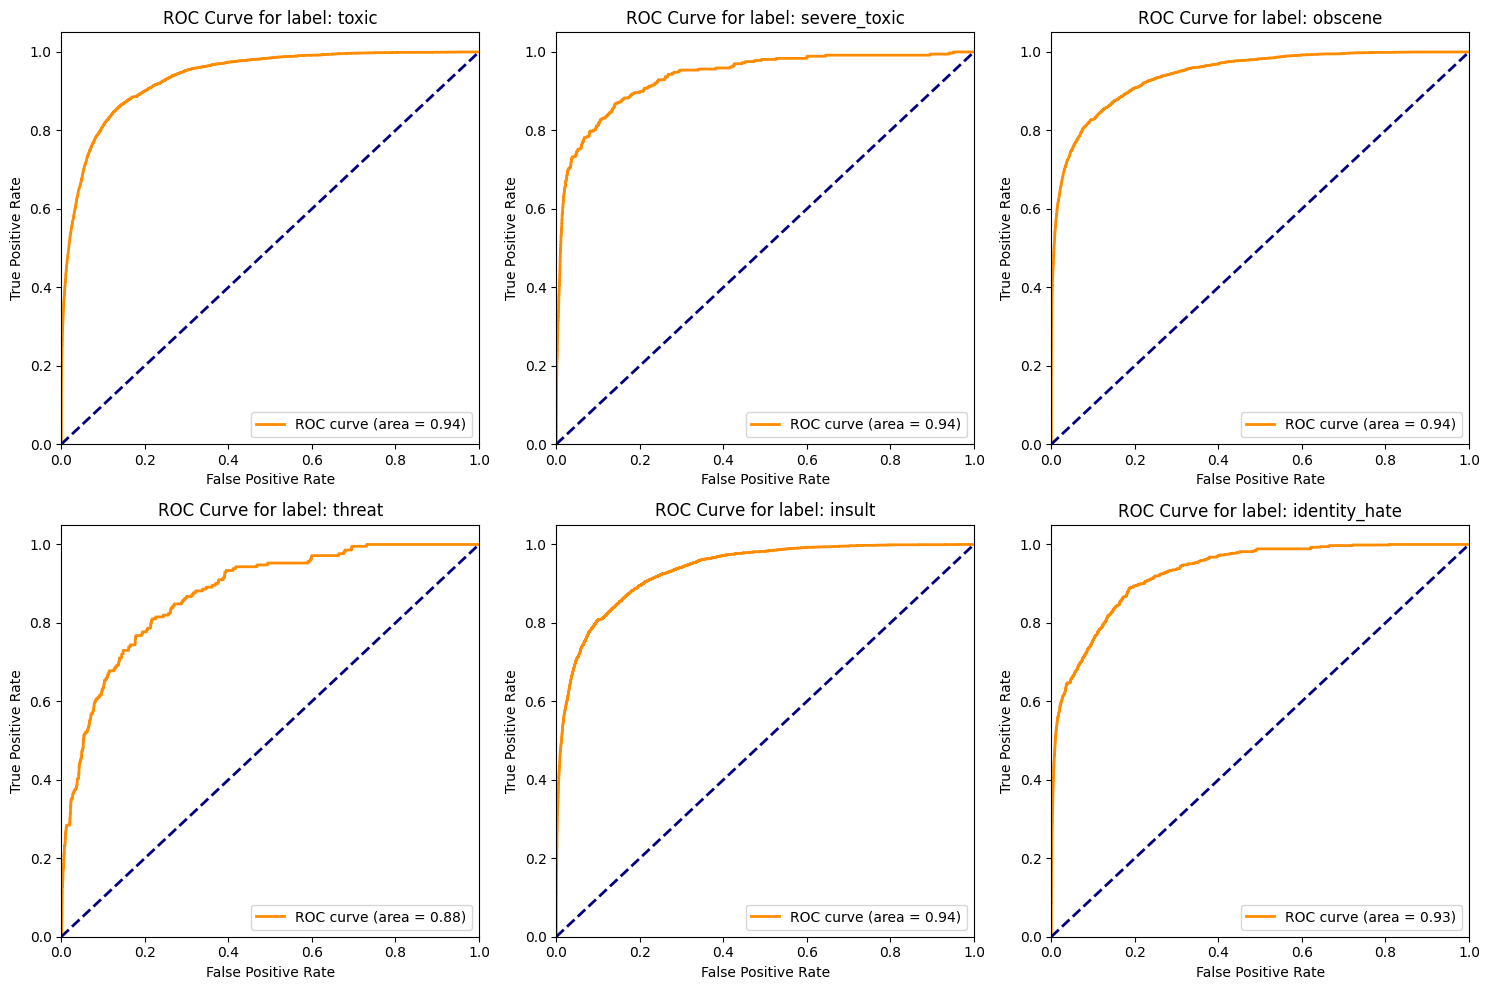

In [28]:
# Objective: Plotting ROC Curves for Binary Classification

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'prd' contains the prediction probabilities for each label in the test set
# and 'y' contains the corresponding true labels

# Plot ROC curves
plt.figure(figsize=(15, 10))

for i, col in enumerate(target_col):
    # Compute ROC curve and ROC area for each label
    fpr, tpr, _ = roc_curve(test[col], prd[:, i])
    roc_auc = auc(fpr, tpr)

    plt.subplot(2, 3, i + 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for label: {col}')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

##AUC curves are relatively good looking wiht high area under the Curves, But we believe this is misleading due to nature of imbalance in class dataset. (and precision recalls being low for class = 1)
#Although we plot AOC curves for this model, lets be real, the AOC is misleading as it is not perfectly capturing class imbalances, so we will ignore it in comparisons.


In [29]:
# Objective: Evaluating Model Performance with Confusion Matrices and Classification Metrics

target_col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Assuming 'test' is your test DataFrame and 'test_pred_binary' contains the binary predictions

# Now, let's calculate the metrics
for col in target_col:
    # Confusion matrix
    cm = confusion_matrix(test[col], test_pred_binary[:, target_col.index(col)])
    print(f"Confusion Matrix for {col}:")
    print(cm)

    # Accuracy, Precision, Recall, and F1-Scores for each class
    accuracy = accuracy_score(test[col], test_pred_binary[:, target_col.index(col)])
    precision_0 = precision_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=0)
    recall_0 = recall_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=0)
    f1_0 = f1_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=0)

    precision_1 = precision_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=1)
    recall_1 = recall_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=1)
    f1_1 = f1_score(test[col], test_pred_binary[:, target_col.index(col)], pos_label=1)

    print(f"Metrics for {col}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision for class 0: {precision_0:.2f}, Recall for class 0: {recall_0:.2f}, F1-Score for class 0: {f1_0:.2f}")
    print(f"Precision for class 1: {precision_1:.2f}, Recall for class 1: {recall_1:.2f}, F1-Score for class 1: {f1_1:.2f}")
    print('-' * 50)

#One thing to note, the Confusion Matrix displayed below has the orderings of TP,TN,FP,FN changed, not as per what displayed in class(This is because)
#The imported Sklearn Confusoin matrix follows the different format.

Confusion Matrix for toxic:
[[48268  9620]
 [  723  5367]]
Metrics for toxic:
Accuracy: 0.84
Precision for class 0: 0.99, Recall for class 0: 0.83, F1-Score for class 0: 0.90
Precision for class 1: 0.36, Recall for class 1: 0.88, F1-Score for class 1: 0.51
--------------------------------------------------
Confusion Matrix for severe_toxic:
[[62871   740]
 [  171   196]]
Metrics for severe_toxic:
Accuracy: 0.99
Precision for class 0: 1.00, Recall for class 0: 0.99, F1-Score for class 0: 0.99
Precision for class 1: 0.21, Recall for class 1: 0.53, F1-Score for class 1: 0.30
--------------------------------------------------
Confusion Matrix for obscene:
[[56748  3539]
 [  847  2844]]
Metrics for obscene:
Accuracy: 0.93
Precision for class 0: 0.99, Recall for class 0: 0.94, F1-Score for class 0: 0.96
Precision for class 1: 0.45, Recall for class 1: 0.77, F1-Score for class 1: 0.56
--------------------------------------------------
Confusion Matrix for threat:
[[63678    89]
 [  204     7]

## Findings

### Toxic:
The model achieves an overall accuracy of 84% in distinguishing toxic and non-toxic comments. Precision for non-toxic comments is high (0.99), with a balanced recall of 0.83. However, for toxic comments, precision drops to 0.36, but recall is higher at 0.88, resulting in an F1-Score of 0.51.

### Severe Toxic:
Impressively, the model attains a high accuracy of 99% in classifying severe toxic and non-severe toxic comments. Precision for non-severe toxic comments is perfect (1.00), with a recall of 0.99. However, for severe toxic comments, precision is lower (0.21), and recall is moderate at 0.53, yielding an F1-Score of 0.30.

### Obscene:
The model performs well in distinguishing obscene and non-obscene comments, achieving an accuracy of 93%. Precision for non-obscene comments is high (0.99), with a balanced recall of 0.94. For obscene comments, precision drops to 0.45, with a higher recall of 0.77, resulting in an F1-Score of 0.56.

### Threat:
With a commendable accuracy of 99%, the model excels in identifying non-threatening and threatening comments. Precision for non-threatening comments is high (0.99), with perfect recall. However, for threatening comments, precision is moderate (0.47), and recall is 0.40, yielding an F1-Score of 0.43.

In summary, the model demonstrates strong performance across various classes, with notable precision-recall trade-offs in identifying toxic and obscene comments. Achieving a balance between precision and recall is crucial for different application scenarios.

## Conclusion
From the findings above it is very clear that Naive Bayes Model is performing excellently on class labels =0, or the absence of Toxic, Severe Toxic, etc. and performing poorly on class labels = 1. It is imperative to see, its not the fault of the model alone(which certainly can be improved upon by state of the art models like Transformers and or even better models like RNNs), this is also because of the Imbalances present in dataset, where in the plots above, it is clearly visible rows with class labels =0 dominate rows with class labels = 1.
While data preprocessing methods could be improved, we believe for this model, the Naive Bayes, it is better to actually shift towards better models like the RNN.


### Thank you